In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras
import csv
import pandas as pd
import random
import numpy as np
from keras import regularizers
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import nltk
nltk.download('wordnet')
import itertools
from string import ascii_lowercase
from functools import reduce
import seaborn as sns
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/PP/final_dataframe.csv'
df=pd.read_csv(path, encoding='latin')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
df = df.dropna(how='any',axis=0)

In [ ]:
df.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 2)

In [ ]:
y = df.sentiment.values
print(y[:5])

[0 0 0 0 0]


In [ ]:
RE_PATTERNS = {
    ' sorry ' : [' soo rry '],
    ' working ' : [' workingg '],
    ' working ipod ' : [' workingipod '],
    ' tonight ' : [' tonightt '],
    ' fuck ' : [' fahk ', ' fcking '],
    ' thank ' : [' thanx '],
    ' come ' : [' comw '],
    ' yuck ' : [' yuk '],
    ' conversation ' : [' convo '],
    ' i do not know ' : [' idunno '],
    ' do not know ' : [' dunno ']
}

In [ ]:
# Text Normalization

def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  return text

In [ ]:
final_tweets = []
for line in tqdm_notebook(df['tweet'], total=1594993):
    final_tweets.append(clean_text(line))

<ipython-input-11-3c41a2331de1>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(df['tweet'], total=1594993):


  0%|          | 0/1594993 [00:00<?, ?it/s]

In [ ]:
final_tweets[:5]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]

In [ ]:
max_features=222342
maxpadlen = 170
val_split = 0.05
embedding_dim_fasttext = 300

In [ ]:
#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(final_tweets))
list_tokenized_train = tokenizer.texts_to_sequences(final_tweets)

In [ ]:
#Indexing
word_index=tokenizer.word_index
print(len(word_index))

690600


In [ ]:
#padding
training_padded=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')

In [ ]:
#Splitting data into Training and Validation Set

x_train, x_val, y_train, y_val = train_test_split(training_padded, y, test_size=0.05, random_state=42)

In [ ]:
embeddings_index_fasttext = {}
f = open('/content/drive/MyDrive/PP/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    line.encode('utf-8').strip()
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

In [ ]:
model_1 = tf.keras.Sequential([
	tf.keras.layers.Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings'),
  tf.keras.layers.Input(shape=(maxpadlen, ),dtype='int32'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.1, return_sequences=True)),
  tf.keras.layers.Conv1D(100, 5, activation='relu'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(30, activation='relu', kernel_initializer='he_uniform'),
	tf.keras.layers.Dropout(.1),
	tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 170, 300)          207180300 
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 bidirectional (Bidirection  (None, 170, 256)          439296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 170, 256)          394240    
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 166, 100)          128100    
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0

In [ ]:
history = model_1.fit(x_train,y_train, epochs=10, batch_size=1024,  validation_data=(x_val, y_val))

Epoch 1/10
1485/1485 [==============================] - 689s 455ms/step - loss: 0.4816 - accuracy: 0.7647 - val_loss: 0.4264 - val_accuracy: 0.8031
Epoch 2/10
1485/1485 [==============================] - 678s 457ms/step - loss: 0.4180 - accuracy: 0.8081 - val_loss: 0.3971 - val_accuracy: 0.8191
Epoch 3/10
1485/1485 [==============================] - 667s 449ms/step - loss: 0.3997 - accuracy: 0.8185 - val_loss: 0.3837 - val_accuracy: 0.8260
Epoch 4/10
1485/1485 [==============================] - 673s 453ms/step - loss: 0.3875 - accuracy: 0.8257 - val_loss: 0.3734 - val_accuracy: 0.8316
Epoch 5/10
1485/1485 [==============================] - 675s 454ms/step - loss: 0.3774 - accuracy: 0.8308 - val_loss: 0.3684 - val_accuracy: 0.8349
Epoch 6/10
1485/1485 [==============================] - 666s 449ms/step - loss: 0.3692 - accuracy: 0.8352 - val_loss: 0.3645 - val_accuracy: 0.8369
Epoch 7/10
1485/1485 [==============================] - 673s 453ms/step - loss: 0.3620 - accuracy: 0.8388 - val_

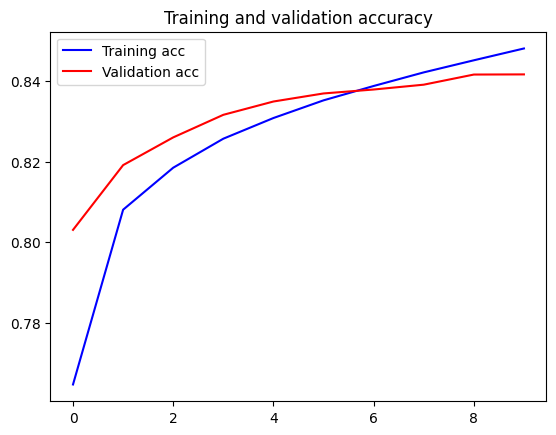

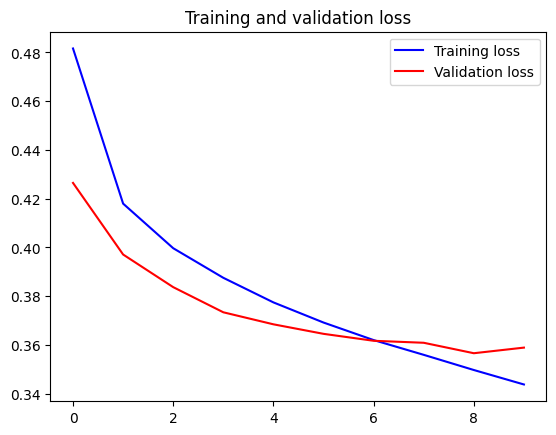

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 [==============================] - 32s 12ms/step


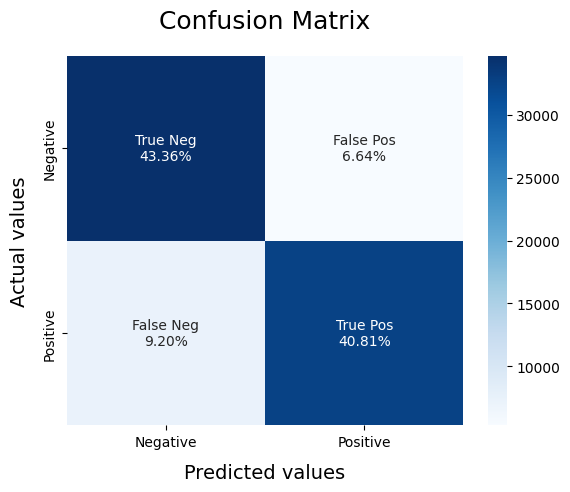

In [ ]:
# Predicting on the Test dataset.
y_pred = model_1.predict(x_val)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
ConfusionMatrix(y_pred, y_val)

In [ ]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85     39999
           1       0.86      0.82      0.84     40001

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [ ]:
import pickle
tf.keras.models.save_model(model_1, '/content/fast_text_model')
pickle.dump(tokenizer, open('/content/tokenizer.pickle', 'wb'))

In [ ]:
tf.keras.models.save_model(model_1, '/content/fast_text_model')

In [ ]:
!zip -r /content/file.zip /content/fast_text_model

  adding: content/fast_text_model/ (stored 0%)
  adding: content/fast_text_model/keras_metadata.pb (deflated 92%)
  adding: content/fast_text_model/assets/ (stored 0%)
  adding: content/fast_text_model/fingerprint.pb (stored 0%)
  adding: content/fast_text_model/variables/ (stored 0%)
  adding: content/fast_text_model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: content/fast_text_model/variables/variables.index (deflated 67%)
  adding: content/fast_text_model/saved_model.pb (deflated 90%)


In [ ]:
from google.colab import files
files.download('tokenizer.pickle')
files.download('file.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>